In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from tqdm import tqdm
import scipy
import spiceypy as spice
import rebound
import reboundx
import matplotlib
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Computer Modern Roman",
  "font.size":    14.0
})

In [2]:
import sys
sys.path.append('..')
from geminids.weights import *
from geminids.beta2mass import asteroidal as asteroidal
from geminids.constants import *
from geminids.cometary_start import init_loc

In [3]:
# orbit = np.load('orbit_time.npy')
# orbit_act = np.load('orbit.npy')
# psp = np.load('psp-week_after.npy')
# psp2 = np.load('psp-week_both.npy')
# t = np.load('t-week_after.npy')
# t2 = np.load('t-week_both.npy')
# psp_vel = np.load('psp-vel.npy')
t_vel = np.load('data/t-vel.npy')

# plt.plot(psp2[:,0], psp2[:,1], c = 'r')
# plt.plot(psp_vel[:,0], psp_vel[:,1], c = 'r')

# psp2 = psp_vel[:,:3]
t2 = t_vel

# plt.plot(orbit[:,0,0], orbit[:,0,1])
# plt.plot(orbit_act[:,0,0], orbit_act[:,0,1])

orbit = np.load('data/phaethon.npy')
psp2 = np.load('data/psp.npy')
t_act = np.load('data/t-3200.npy')
earth = spice.convrt(np.load('data/earth.npy'), "AU", "M")


In [4]:
spice.furnsh("data/meta.tm")

In [5]:

t_start = spice.str2et('2017-01-01')
beg = spice.str2et('2017-01-01')
end = spice.str2et('2019-01-01')

pts_per_year = 365*24*60
n_particles = 1
n_years = 2


[y0, lt] = spice.spkezr('2003200', t_start, 'J2000', 'NONE', 'SUN')
y0 = spice.convrt(y0, "KM", "AU")


n = 1


# sim = rebound.Simulation("/content/gdrive/MyDrive/Research/Su_2021/J+Inner.bin")
sim = rebound.Simulation()


sim.units = ('s', 'AU', 'Msun')
sim.dt = -.001
sim.add(m=1.)

[yj, lt] = spice.spkezr("JUPITER BARYCENTER", t_start, "J2000", "NONE", "SUN")
yj = spice.convrt(yj, "KM", "AU")
sim.add(m=0.000954588, x=yj[0], y=yj[1], z=yj[2], vx=yj[3], vy=yj[4], vz=yj[5])
print("Added Jupiter...")

[e_pos, lt] = spice.spkezr('EARTH', t_start, 'J2000', 'NONE', 'SUN')
e_pos = spice.convrt(e_pos, 'KM', 'AU')
sim.add(m=MASS_E/MASS_SUN, x=e_pos[0], y=e_pos[1], z=e_pos[2], vx=e_pos[3], vy=e_pos[4], vz=e_pos[5])
print("Added Earth...")


[mr_pos, lt] = spice.spkezr('4', t_start, 'J2000', 'NONE', 'SUN')
mr_pos = spice.convrt(mr_pos, 'KM', 'AU')
sim.add(m=MASS_MR/MASS_SUN, x=mr_pos[0], y=mr_pos[1], z=mr_pos[2], vx=mr_pos[3], vy=mr_pos[4], vz=mr_pos[5])
print("Added Mars...")



[v_pos, lt] = spice.spkezr('VENUS', t_start, 'J2000', 'NONE', 'SUN')
v_pos = spice.convrt(v_pos, 'KM', 'AU')
sim.add(m=MASS_V/MASS_SUN, x=v_pos[0], y=v_pos[1], z=v_pos[2], vx=v_pos[3], vy=v_pos[4], vz=v_pos[5])
print("Added Venus...")



[hg_pos, lt] = spice.spkezr('MERCURY', t_start, 'J2000', 'NONE', 'SUN')
hg_pos = spice.convrt(hg_pos, 'KM', 'AU')
sim.add(m=MASS_HG/MASS_SUN, x=hg_pos[0], y=hg_pos[1], z=hg_pos[2], vx=hg_pos[3], vy=hg_pos[4], vz=hg_pos[5])
print("Added Mercury...")


n_active = len(sim.particles)




sim.n_active = n_active
sim.collision = "none"



sim.move_to_hel()
print("adding particles...")

sim.add(x = y0[0], y=y0[1], z=y0[2], vx=y0[3], vy = y0[4], vz = y0[5])
sim.move_to_com()




print("time arrays...")

Noutputs = n_years*pts_per_year
year = spice.jyear()
times = np.linspace(end-t_start, beg-t_start, int(Noutputs))


t2 = np.linspace(0, end-t_start, int(1600 + 3000)*100)
pos = np.zeros((n,int(Noutputs),3))

sim.move_to_com()        
ps = sim.particles      



xy = np.zeros((int(Noutputs),6))
xy2 = np.zeros((int(1600 + 3000)*100,3))
d = np.zeros(int(Noutputs))
print("simulating...")
p = sim.particles[6]

for i, time in enumerate(tqdm(t2)):
    sim.integrate(time)
    xy2[i] = [p.x, p.y, p.z]    
for i, time in enumerate(tqdm(times)):
    sim.integrate(time)
    sim.move_to_hel()
    xy[i] = [p.x, p.y, p.z, p.vx, p.vy, p.vz]
    d[i] = spice.vnorm(xy[i][0:3])
    sim.move_to_com()

start_date = t_start

  1%|          | 4384/460000 [00:00<00:10, 43837.43it/s]

Added Jupiter...
Added Earth...
Added Mars...
Added Venus...
Added Mercury...
adding particles...
time arrays...
simulating...


100%|██████████| 1051200/1051200 [00:45<00:00, 23086.97it/s]


In [6]:
idxmin = np.argmin(d)
t_start = times[idxmin] + start_date
perihelion = xy[idxmin]



date_start = spice.et2utc(t_start, "C", 14)
date_start

'2018 JAN 25 08:12:32.0000246763229'

100%|██████████| 730/730 [00:00<00:00, 34613.51it/s]


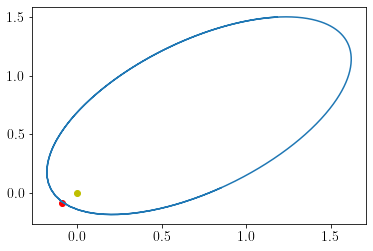

2018 JAN 25 08:12:32


In [7]:
x = np.array([0,0,0])
t = np.linspace(spice.str2et('1600-01-01'), spice.str2et('1602-01-01'), num=365*2)
for time in tqdm(t):
  [pos, lt] = spice.spkpos("2003200", time, "J2000", "NONE", "SUN")
  x = np.vstack((x, pos))

x = x[1:]
plt.plot(x[:,0]/AU_TO_M*1e3, x[:,1]/AU_TO_M*1e3)
plt.scatter(perihelion[0], perihelion[1], c='r')
plt.scatter(0, 0, c='y' )
plt.show()
print(spice.et2utc(t_start, "C", 0))

In [8]:
perihelion = spice.convrt(perihelion, "AU", "M")

p_vel = np.sqrt(np.sum(perihelion[3:] ** 2))

In [9]:
p_vel

109460.94567645801

In [10]:
points = []
n = 100

mass_nv = 0
for i in tqdm(range(n)):
    data = np.load(f'../output/novel/particles{i}.npy')
    beta = np.load(f'../output/novel/beta{i}.npy')
    size = np.array(asteroidal(beta))
    
    mass_nv += np.sum(size[(~np.isnan(size * weight_novel(beta)))] * 
                   weight_novel(beta[(~np.isnan(size * weight_novel(beta)))]))
    
    data = data.reshape(1000*100*2, 5)
    data = data[:,:3]
    
#     data[:,2] -= offset(data[:,1])
    
    
    points.append(np.hstack((data, np.tile(size,2000).reshape(200000,1), 
                              np.tile(weight_novel(beta),2000).reshape(200000,1))))

mass_nv *=20000
points = np.array(points)
points = points.reshape(200000*n,5)

100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


In [11]:
transform = spice.pxform("J2000", "ECLIPJ2000", 0)

print("Transforming")
psp2 = psp2[:,:3].copy()

# points_novel[:,:3] = np.dot(transform, points_novel[:,:3].T).T
# points_vel[:,:3] = np.dot(transform, points_vel[:,:3].T).T
# points_distr[:,:3] = np.dot(transform, points_distr[:,:3].T).T
psp2 = np.dot(transform, psp2.T).T

Transforming


In [12]:
print(f"removing at least {points[points[:,0] > 0.5].shape[0]} of {points.shape[0]} points")
points = points[points[:,0] < 0.1]
points = points[points[:,1] < 0.1]

print("removed")
particles = scipy.spatial.KDTree(points[:,:3])

removing at least 15909252 of 20000000 points
removed


In [13]:
points2 = []
n=100
mass_v = 0
for i in tqdm(range(n)):
    data = np.load(f'../output/vel/particles{i}.npy')
    beta = np.load(f'../output/vel/beta{i}.npy')
    size = asteroidal(beta)
    
    
    data = data.reshape(1000*100*2, 5)
    data = data[:,:3]
    
#     data[:,2] -= offset(data[:,1])
    mass_v += np.sum(size[(~np.isnan(size * weight_vel(beta)))] * weight_vel(beta[(~np.isnan(size * weight_vel(beta)))]))

    
    points2.append(np.hstack((data, np.tile(size,2000).reshape(200000,1), np.tile(weight_vel(beta),2000).reshape(200000,1))))
    
mass_v *=2000
points2 = np.array(points2)
points2 = points2.reshape(200000*n,5)



100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


In [14]:
points2 = points2[points2[:,0] < 0.1]
points2 = points2[points2[:,1] < 0.1]
particles2 = scipy.spatial.KDTree(points2[:,:3])

In [15]:
points3 = []
pth = "../output/"
offset = 0
mass_d = 0
n = 100
orbit = np.load("../data/orig_orbit.npy")
for i in tqdm(range(n*10)):
        # try:
            data = np.load(f'{pth}comet/particles{i}.npy')
            beta = np.load(f'{pth}comet/beta{i}.npy')
            size = np.load(f'{pth}comet/mass{i}.npy')
            mask = beta < .5
            size[mask] = asteroidal(beta[mask])
            size[~mask] = 0
            data = data.reshape(10000*10*2, 5)
            # try:
                
            __, r, t = init_loc(int(i/10), orbit)
            t = np.tile(t, 100)
            r = np.tile(r, 100)
            # except Exception as e:
                # print(e)
            # data[data[:,4] < .2] *= 0
            data = data[:,:3]
            # beta = np.tile(beta, 20000).reshape(200000,)
            # print(beta.shape)
            mask = ~np.isnan(size * weight_cometary(beta, r, t))
            mass_d += np.sum(size[mask] * 
                             weight_cometary(beta[mask],
                                                  r[mask],
                                                  t[mask]))

            # w = weight_cometary(beta, r, t)
            # print(w.shape)
            # print(r)

            points3.append(np.hstack((data, np.tile(size,2000).reshape(200000,1), 
                                   np.tile(weight_cometary(beta, r, t),2000).reshape(200000,1),
                                   np.tile(r,2000).reshape(200000,1))))
        # except Exception as e: 
        #     print(e)
        #     offset +=1

points3 = np.array(points3)
points3 = points3.reshape(200000*(n*10 - offset),6)




 11%|█         | 108/1000 [01:56<15:06,  1.02s/it]../geminids/weights.py:40: RuntimeWarning: invalid value encountered in greater
  arr[mask][asteroidal(b[mask]) > 10] = 0
../geminids/weights.py:41: RuntimeWarning: invalid value encountered in less
  arr[mask][asteroidal(b[mask]) < 1e-16] = 0
100%|██████████| 1000/1000 [17:52<00:00,  1.07s/it]


In [16]:
points3 = points3[points3[:,0] < 0.1]
points3 = points3[points3[:,1] < 0.1]
particles3 = scipy.spatial.KDTree(points3[:,:3])

In [17]:
norm = 1e15/mass_nv
norm2 = 1e15/mass_v
norm3 = 1e15/mass_d

In [18]:
impact = pd.read_csv('data/psp_imp_rate_orb04.txt', sep = '\s+')
spice.furnsh("data/meta.tm")
t3 = spice.str2et(impact["Time"])






In [19]:
psp_vel = psp2
n_part_vel = np.zeros((int(psp2.shape[0]/100)))
r_vel = np.zeros((int(psp2.shape[0]/100)))


n_part_no_vel = np.zeros((int(psp2.shape[0]/100)))
r_no_vel = np.zeros((int(psp2.shape[0]/100)))


n_part_distr = np.zeros((int(psp2.shape[0]/100)))
r_distr = np.zeros((int(psp2.shape[0]/100)))

r = 0.05
psp_t = []


for i in tqdm(range(int(psp2.shape[0]/100))):
        psp_t.append(t_vel[i*100])

        n_part_vel[i] = np.sum(points2[particles2.query_ball_point(psp2[i*100], r), 4])
        n_part_distr[i] = np.sum(points3[particles3.query_ball_point(psp2[i*100], r), 4])
        n_part_no_vel[i] = np.sum(points[particles.query_ball_point(psp2[i*100], r), 4])
        

        V = 4/3 * np.pi * (r*au)**3

        r_vel[i] = n_part_vel[i]/V * norm2 * (5) * (np.sqrt(np.sum(psp_vel[i,3:]**2)) + p_vel)
        #                      m^-3. n/a.   m^2            m/s                         m/s                                               
        
        
        r_distr[i] = n_part_distr[i]/V * norm3 * (5) * (np.sqrt(np.sum(psp_vel[i,3:]**2)) + p_vel)
        r_no_vel[i] = n_part_no_vel[i]/V * norm * (5) * (np.sqrt(np.sum(psp_vel[i,3:]**2)) + p_vel)

100%|██████████| 800/800 [00:53<00:00, 14.86it/s]


In [20]:
n_mass_vel = np.zeros((int(psp2.shape[0]/100)))
n_mass_no_vel = np.zeros((int(psp2.shape[0]/100)))
n_mass_distr = np.zeros((int(psp2.shape[0]/100)))



for i in tqdm(range(int(psp2.shape[0]/100))):
        n_mass_distr[i] = np.median(points3[:,3][particles3.query_ball_point(psp2[i*100], r)])
        n_mass_vel[i] = np.median(points2[:,3][particles2.query_ball_point(psp2[i*100], r)])
        n_mass_no_vel[i] = np.median(points[:,3][particles.query_ball_point(psp2[i*100], r)])

  0%|          | 0/800 [00:00<?, ?it/s]/Users/wolfcukier/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wolfcukier/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 800/800 [00:52<00:00, 15.26it/s]


In [21]:
# fig = plt.figure()
# ax = fig.add_subplot(311)

# x2 = np.array([t_vel[i*100] for i in range(800)])
# x2 = mdates.datestr2num(spice.et2utc(psp_t, "C", 3))

# l1 = ax.plot(x2, r_no_vel, label = "rate")

# ax2 = ax.twinx()

# l2 = ax2.plot(x2, n_mass_no_vel*1e6, '--r', label = "mass")


# ax2.set_ylabel("Median Mass ($\mu$g)")
# ax.set_ylabel("Impact Rate (s$^{-1}$)")
# ax.set_xlabel("Date")



# lns = l1+l2
# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc=0)


# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
# plt.gcf().autofmt_xdate()

# ax = fig.add_subplot(312)

# x2 = np.array([t2[i*100] for i in range(800)])
# x2 = mdates.datestr2num(spice.et2utc(x2, "C", 3))

# l1 = ax.plot(x2, r_vel, label = "rate")

# ax2 = ax.twinx()

# l2 = ax2.plot(x2, n_mass_vel*1e6, '--r', label = "mass", )


# ax2.set_ylabel("Median Mass ($\mu$g)")
# ax.set_ylabel("Impact Rate (s$^{-1}$)")
# ax.set_xlabel("Date")



# lns = l1+l2
# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc=0)


# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
# plt.gcf().autofmt_xdate()


# ax = fig.add_subplot(313)

# # x2 = np.array([t2[i*100] for i in range(800)])
# # x2 = mdates.datestr2num(spice.et2utc(x2, "C", 3))

# # # l1 = ax.plot(x2, r_distr, label = "rate")

# # ax2 = ax.twinx()

# # l2 = ax2.plot(x2, n_mass_distr*1e6, '--r', label = "mass", )


# # ax2.set_ylabel("Median Mass ($\mu$g)")
# # ax.set_ylabel("Impact Rate (s$^{-1}$)")
# # ax.set_xlabel("Date")



# lns = l1+l2
# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc=0)


# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
# plt.gcf().autofmt_xdate()
# plt.show()


# plt.plot(x2,r_no_vel, label = "Base Model")
# plt.plot(x2,r_vel, label="Violent Creation")
# # plt.plot(x2,r_distr, label="Distributed Creation")
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
# plt.gcf().autofmt_xdate()
# t2=psp_t

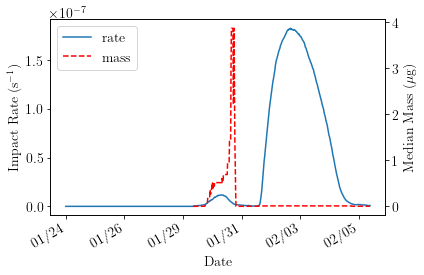

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

# x2 = np.array([t2[i*100] for i in range(800)])
x2 = mdates.datestr2num(spice.et2utc(psp_t, "C", 3))

l1 = ax.plot(x2, r_vel, label = "rate")

ax2 = ax.twinx()

l2 = ax2.plot(x2, n_mass_vel*1e6, '--r', label = "mass", )


ax2.set_ylabel("Median Mass ($\mu$g)")
ax.set_ylabel("Impact Rate (s$^{-1}$)")
ax.set_xlabel("Date")



lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.gcf().autofmt_xdate()



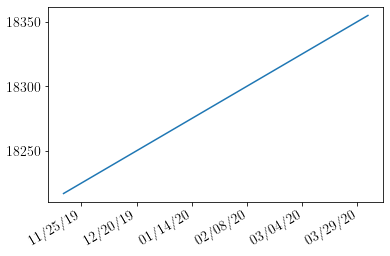

In [23]:
times = mdates.datestr2num(spice.et2utc(t3, "C", 3))
times_a = mdates.datestr2num(spice.et2utc(t_vel, "C", 3))



plt.plot(times,times)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gcf().autofmt_xdate()

Get the density of the psp data = (rate * 1 day) / (5m^2 * distance covered in that day)

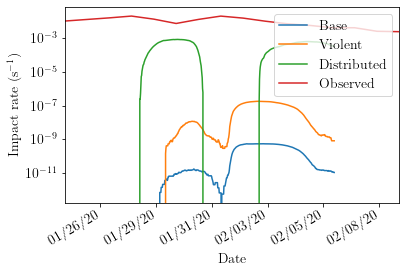

In [30]:
beg  = 45
end = 60

plt.plot(x2,r_no_vel, label = "Base")
plt.plot(x2,r_vel, label="Violent")
plt.plot(x2,r_distr, label="Distributed")

plt.plot(times, impact["Rate"][:], label = 'Observed')

plt.xlim(times[beg], times[end])
plt.legend(loc=1)
plt.yscale("log")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Impact rate (s$^{-1}$)")
plt.savefig("../figures/psp.png")
plt.show()


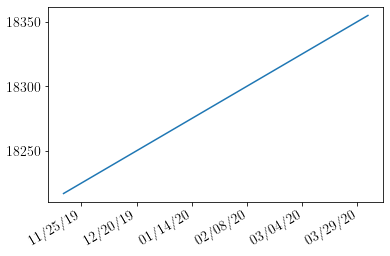

In [25]:
times = mdates.datestr2num(spice.et2utc(t3, "C", 3))
times_a = mdates.datestr2num(spice.et2utc(t_vel, "C", 3))



plt.plot(times,times)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
plt.gcf().autofmt_xdate()

In [26]:
impact["Density"] = impact["Rate"] * DAY_TO_SEC
impact.loc[-1, "Density"] = np.NaN
for i in range(impact.shape[0] - 2):
    dx = np.abs(impact.loc[i, "x"] - impact.loc[i+1, "x"])
    dy = np.abs(impact.loc[i, "y"] - impact.loc[i+1, "y"])
    dz = np.abs(impact.loc[i, "z"] - impact.loc[i+1, "z"])


    impact.loc[i, "Density"] /= (np.sqrt(dx**2 + dy**2 + dz**2)* 1000 * 5)
    


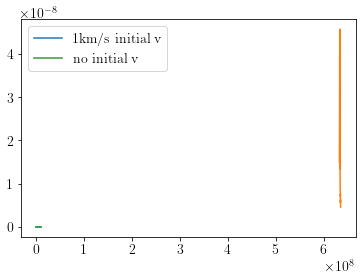

In [27]:
x = np.arange(800)/800*14 - 7

plt.rc_context({'figure.facecolor':'white'})

x2 = np.array([t2[i*100] for i in range(800)])

V = 4/3 * np.pi * r**3

plt.plot(x2, n_part_vel/V*norm/(au**3), label = '~1km/s initial v')

plt.plot(t3[41:71], impact["Density"][41:71])
plt.plot(x2, n_part_no_vel/V*norm/(au**3), label = 'no initial v')
plt.legend()



In [28]:
np.max(n_part_no_vel/V*norm/au**3)

9.98104918451068e-16

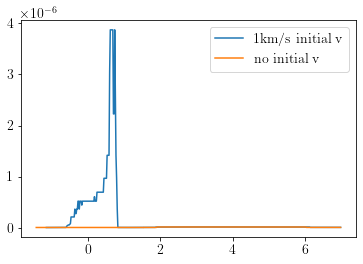

In [29]:
x = np.arange(800)/800*14 - 7

plt.rc_context({'figure.facecolor':'white'})



plt.plot(x, n_mass_vel, label = '~1km/s initial v')
plt.plot(x, n_mass_no_vel, label = 'no initial v')
plt.legend()

